In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import os
import json
from json.decoder import JSONDecodeError
import glob

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets


# Import API key
from api_keys import propublica_api_key

from api_keys import g_key

plt.rcParams['font.size'] = 12.0

In [3]:
#input_data_file1 = "output_data/bills_s_115.csv"

path = r'output_data/' # use your path
all_files = glob.glob(path + "/bills*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

bills_df = pd.concat(li, axis=0, ignore_index=True)

In [4]:
bills_df.head(5)

,bill_slug,congress,bill_id,bill_type,bill_uri,short_title,sponsor_title,sponsor_id,sponsor_name,sponsor_state,...,house_passage,senate_passage,enacted,vetoed,cosponsors,cosponsors_by_party_D,cosponsors_by_party_R,committees,committee_codes,primary_subject
0,hr1,113,hr1-113,hr,https://api.propublica.org/congress/v1/113/bil...,Tax Reform Act of 2014,Rep.,C000071,Dave Camp,MI,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,House Ways and Means Committee,['HSWM'],Taxation
1,hr2,113,hr2-113,hr,https://api.propublica.org/congress/v1/113/bil...,American Energy Solutions for Lower Costs and ...,Rep.,T000459,Lee Terry,NE,...,2014-09-18,NaN,NaN,NaN,15.0,NaN,15.0,House Energy and Commerce Committee,"['HSII', 'HSSY', 'HSJU', 'HSPW', 'HSIF']",Energy
2,hr3,113,hr3-113,hr,https://api.propublica.org/congress/v1/113/bil...,Northern Route Approval Act,Rep.,T000459,Lee Terry,NE,...,2013-05-22,NaN,NaN,NaN,134.0,2.0,132.0,House Natural Resources Committee,"['HSII', 'HSPW', 'HSIF']",Energy
3,hr4,113,hr4-113,hr,https://api.propublica.org/congress/v1/113/bil...,Jobs for America Act,Rep.,C000071,Dave Camp,MI,...,2014-09-18,NaN,NaN,NaN,4.0,NaN,4.0,House Judiciary Committee,"['HSWM', 'HSSM', 'HSII', 'HSAG', 'HSBA', 'HSJU...",Economics and Public Finance
4,hr5,113,hr5-113,hr,https://api.propublica.org/congress/v1/113/bil...,Student Success Act,Rep.,K000363,John Kline,MN,...,2013-07-19,NaN,NaN,NaN,12.0,NaN,12.0,"Senate Health, Education, Labor, and Pensions ...","['SSHR', 'HSED', 'HSBA']",Education


In [21]:
total_number_bills = bills_df.count()[0]


total_number_bills_per_congress= bills_df.groupby(["congress"]).count()
total_number_bills

40314

In [6]:
#find CARES Act in data set
cares_act = bills_hr = bills_df.loc[(bills_df["bill_slug"] == "hr748") & (bills_df["congress"] == 116)]
cares_act

,bill_slug,congress,bill_id,bill_type,bill_uri,short_title,sponsor_title,sponsor_id,sponsor_name,sponsor_state,...,house_passage,senate_passage,enacted,vetoed,cosponsors,cosponsors_by_party_D,cosponsors_by_party_R,committees,committee_codes,primary_subject
20545,hr748,116,hr748-116,hr,https://api.propublica.org/congress/v1/116/bil...,CARES Act,Rep.,C001069,Joe Courtney,CT,...,3/27/2020,3/25/2020,NaN,NaN,369.0,201.0,168.0,House Ways and Means Committee,[],Economics and Public Finance


In [19]:
#make a df for house, and one for senate
bills_hr = bills_df.loc[bills_df["bill_type"] == "hr"]
total_number_bills_hr = bills_hr.count()
bills_s = bills_df.loc[bills_df["bill_type"] == "s"]
total_number_bills_s = bills_s.count()

#number of each type grouped by period
congress_group_hr= bills_hr.groupby(["congress"]).count()
congress_group_s= bills_s.groupby(["congress"]).count()

#percent calc
congress_group_hr["percent"] = round(congress_group_hr["bill_slug"]/total_number_bills_per_congress["bill_slug"]*100, 1).astype(str) + '%'
congress_group_s["percent"] = round(congress_group_s["bill_slug"]/total_number_bills_per_congress["bill_slug"]*100, 1).astype(str) + '%'

reindex_congress_group_hr = congress_group_hr.reset_index()
reindex_congress_group_s = congress_group_s.reset_index()

#create stacked bar chart of bills introduced by chamber

fig1 = go.Figure(data=[
    go.Bar(name='House of Representitives', x=reindex_congress_group_hr["congress"], y=reindex_congress_group_hr["bill_slug"], text = reindex_congress_group_hr["percent"], textposition='auto', marker_color = "orange"),
    go.Bar(name='Senate', x=reindex_congress_group_s["congress"], y=reindex_congress_group_s["bill_slug"], text = reindex_congress_group_s["percent"], textposition='auto')
])

# Change the bar mode
fig1.update_layout(barmode='stack', 
    title="Bills Introduced", 
    xaxis_title="Congress",
    yaxis_title="Number of Bills",
    xaxis_type='category')
fig1.show()

In [8]:
#save figure as png
#fig.write_image("figure_output/bills_by_hr_s.png")


In [20]:
#create t/f column if bill was enacted then new enacted df
bills_hr["enacted_t_f"] = bills_hr["enacted"].notnull()
bills_enacted_hr = bills_hr.loc[bills_hr['enacted_t_f'] == True]

bills_s["enacted_t_f"] = bills_s["enacted"].notnull()
bills_enacted_s = bills_s.loc[bills_s['enacted_t_f'] == True]


congress_bills_enacted_hr= bills_enacted_hr.groupby(["congress"]).count()
congress_bills_enacted_s= bills_enacted_s.groupby(["congress"]).count()

#percent calc

total_number_bills_enacted_per_congress = (congress_bills_enacted_hr["bill_slug"]+congress_bills_enacted_s["bill_slug"])

#percent calc
congress_bills_enacted_hr["percent"] = round(congress_bills_enacted_hr["bill_slug"]/total_number_bills_enacted_per_congress*100, 1).astype(str) + '%'
congress_bills_enacted_s["percent"] = round(congress_bills_enacted_s["bill_slug"]/total_number_bills_enacted_per_congress*100, 1).astype(str) + '%'

reindex_congress_bills_enacted_hr = congress_bills_enacted_hr.reset_index()
reindex_congress_bills_enacted_s = congress_bills_enacted_s.reset_index()


#create stacked bar chart of enacted bills by chamber

fig2 = go.Figure(data=[
    go.Bar(name='House of Representitives', x=reindex_congress_bills_enacted_hr["congress"], y=reindex_congress_bills_enacted_hr["bill_slug"], text = reindex_congress_bills_enacted_hr["percent"], textposition='auto', marker_color = "orange"),
    go.Bar(name='Senate', x=reindex_congress_bills_enacted_s["congress"], y=reindex_congress_bills_enacted_s["bill_slug"], text = reindex_congress_bills_enacted_s["percent"], textposition='auto')
])

#fig2 = go.FigureWidget(data=[
    #go.Bar(name='House of Representitives', x=reindex_congress_bills_enacted_hr["congress"], y=reindex_congress_bills_enacted_hr["bill_slug"], text = reindex_congress_bills_enacted_hr["bill_slug"], textposition='auto', marker_color = "orange"),
    #go.Bar(name='Senate', x=reindex_congress_bills_enacted_s["congress"], y=reindex_congress_bills_enacted_s["bill_slug"], text = reindex_congress_bills_enacted_s["bill_slug"], textposition='auto')
#])
# Change the bar mode
fig2.update_layout(barmode='stack', 
    title="Bills Enacted", 
    xaxis_title="Congress",
    yaxis_title="Number of Bills",
    xaxis_type='category')
fig2.show()

C:\Users\hboll\Anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hboll\Anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
mem_hr=435
mem_s=100
chambers =['House', 'Senate']
fig3 = px.pie(df, values=[mem_hr, mem_s], names= chambers, color=chambers,
             color_discrete_map={'House':'orange',
                                 'Senate':'EF553B',
                                 })
fig3.update_layout(title = {'text': "Member Distribution Between Chambers",'x':0.5,'xanchor': 'center'})
fig3.show()

In [14]:
bills_active = bills_df.loc[bills_df['active'] == True]
bills_active.count()
bills_inactive = bills_df.loc[bills_df['active'] == False]
bills_inactive.count()
bills_inactive.reindex()


,bill_slug,congress,bill_id,bill_type,bill_uri,short_title,sponsor_title,sponsor_id,sponsor_name,sponsor_state,...,senate_passage,enacted,vetoed,cosponsors,cosponsors_by_party_D,cosponsors_by_party_R,committees,committee_codes,primary_subject,enacted_t_f
0,hr1,113,hr1-113,hr,https://api.propublica.org/congress/v1/113/bil...,Tax Reform Act of 2014,Rep.,C000071,Dave Camp,MI,...,NaN,NaN,NaN,0.0,NaN,NaN,House Ways and Means Committee,['HSWM'],Taxation,False
10,hr11,113,hr11-113,hr,https://api.propublica.org/congress/v1/113/bil...,Violence Against Women Reauthorization Act of ...,Rep.,M001160,Gwen Moore,WI,...,NaN,NaN,NaN,200.0,201.0,NaN,House Education and the Workforce Committee,"['HSII', 'HSBA', 'HSED', 'HSIF', 'HSJU']",Crime and Law Enforcement,False
11,hr12,113,hr12-113,hr,https://api.propublica.org/congress/v1/113/bil...,Voter Empowerment Act of 2013,Rep.,L000287,John Lewis,GA,...,NaN,NaN,NaN,179.0,179.0,NaN,House Education and the Workforce Committee,"['HSED', 'HSGO', 'HSVR', 'HSSY', 'HSJU', 'HSHA']",Government Operations and Politics,False
19,hr20,113,hr20-113,hr,https://api.propublica.org/congress/v1/113/bil...,Government By the People Act of 2014,Rep.,S001168,John Sarbanes,MD,...,NaN,NaN,NaN,160.0,159.0,1.0,House Energy and Commerce Committee,"['HSWM', 'HSIF', 'HSHA']",Government Operations and Politics,False
20,hr21,113,hr21-113,hr,https://api.propublica.org/congress/v1/113/bil...,NRA Members' Gun Safety Act of 2013,Rep.,M000933,James P. Moran,VA,...,NaN,NaN,NaN,2.0,2.0,NaN,House Judiciary Committee,['HSJU'],Crime and Law Enforcement,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40308,s3582,116,s3582-116,s,https://api.propublica.org/congress/v1/116/bil...,A bill to amend the Internal Revenue Code of 1...,Sen.,C000127,Maria Cantwell,WA,...,NaN,NaN,NaN,3.0,3.0,NaN,Senate Finance Committee,[],Taxation,False
40309,s3583,116,s3583-116,s,https://api.propublica.org/congress/v1/116/bil...,Protecting Collective Bargaining and Official ...,Sen.,C000141,Benjamin L. Cardin,MD,...,NaN,NaN,NaN,13.0,12.0,NaN,Senate Homeland Security and Governmental Affa...,[],Government Operations and Politics,False
40310,s3584,116,s3584-116,s,https://api.propublica.org/congress/v1/116/bil...,COVID-19 Workers First Protection Act of 2020,Sen.,B001230,Tammy Baldwin,WI,...,NaN,NaN,NaN,1.0,1.0,NaN,"Senate Health, Education, Labor, and Pensions ...",[],Labor and Employment,False
40311,s3585,116,s3585-116,s,https://api.propublica.org/congress/v1/116/bil...,Moratorium on Coronavirus Evictions Act,Sen.,J000300,Doug Jones,AL,...,NaN,NaN,NaN,1.0,1.0,NaN,"Senate Banking, Housing, and Urban Affairs Com...",[],Housing and Community Development,False


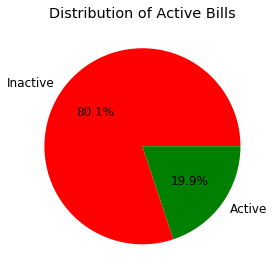

In [15]:
active_grouped = bills_df.groupby(["active"]).count()
plt.pie(active_grouped["bill_slug"], labels = ["Inactive", "Active"], colors = ["red", "green"], autopct="%1.1f%%")
plt.title("Distribution of Active Bills")
plt.tight_layout()
plt.show()

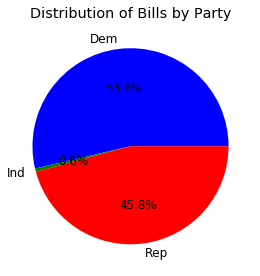

In [16]:
party_intro_grouped = bills_df.groupby(["sponsor_party"]).count()
plt.pie(party_intro_grouped["bill_slug"], labels = ["Dem", "Ind", "Rep"], colors = ["b", "green", "r"], autopct="%1.1f%%")
plt.title("Distribution of Bills by Party")
plt.tight_layout()
plt.show()

In [17]:
party_intro_grouped = bills_df.groupby(["sponsor_party"]).count()
party_intro_grouped

,bill_slug,congress,bill_id,bill_type,bill_uri,short_title,sponsor_title,sponsor_id,sponsor_name,sponsor_state,...,senate_passage,enacted,vetoed,cosponsors,cosponsors_by_party_D,cosponsors_by_party_R,committees,committee_codes,primary_subject,enacted_t_f
sponsor_party,,,,,,,,,,,,,,,,,,,,,
D,21627,21627,21627,21627,21627,21621,21621,21627,21627,21627,...,592,352,0,21627,15484,8540,21544,21627,21405,21627
I,226,226,226,226,226,226,226,226,226,226,...,4,2,0,226,138,57,223,226,226,226
R,18459,18459,18459,18459,18459,18457,18457,18459,18459,18459,...,897,618,1,18459,9189,12287,18321,18459,18371,18459
